In [180]:
import logging
logging.getLogger('tenpy').setLevel(logging.WARNING)

from tenpy.models.spins import SpinChain
from tenpy.networks.mps import MPS, InitialStateBuilder
from tenpy.algorithms.tebd import RandomUnitaryEvolution
from tenpy.algorithms import dmrg
from tenpy.networks.mpo import MPO
from tenpy.models.aklt import AKLTChain
from tenpy.algorithms import dmrg
from tenpy.networks.purification_mps import PurificationMPS
from tenpy.networks.site import SpinSite

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
import time
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit


## Numerical ground state search via finite DMRG

In [14]:
def generate_random_mps(model, psi0=None, chi_max=50, N_steps=20):

    """    Generate a random MPS for the given model and evolve it using a random unitary evolution.
    Args:
        model: The model for which the MPS is generated.
        psi0: Initial state of the MPS, if None, a product state of "0.0" is used.
        chi_max: Maximum bond dimension for the MPS.
        N_steps: Number of steps for the random unitary evolution.
    Returns:
        psi: The evolved MPS after the random unitary evolution.
    """



    sites = model.lat.mps_sites()
    L = model.lat.N_sites
    if psi0 is None:
        possible_states = ["down", "up", "0.0"]
        psi0 = np.random.choice(possible_states, L)

        psi0 = ["0.0"] * L
    psi = MPS.from_product_state(sites, psi0 , bc=model.lat.bc_MPS)

    rand_opts = {
        'N_steps': N_steps,
        'trunc_params': {'chi_max': chi_max},
        'dt': 1.0
    }
    engine = RandomUnitaryEvolution(psi, rand_opts)
    engine.run()
    psi.canonical_form()

    return psi

In [163]:
# Settings for the DMRG algorithm

L = 200
chi_max = 10

model = AKLTChain({'L': L, 'bc_MPS': 'finite'})
psi_gs = model.psi_AKLT()  


dmrg_params = {
    'mixer': True,
    'max_E_err': 1e-9,
    'max_sweeps': 50,
    'min_sweeps': 30,
    'trunc_params': {'chi_max': chi_max},
    'max_trunc_err': 1e-9,
    'E_tol_to_trunc': 1e-9,
    'P_tol_to_trunc': 1e-9
}

possible_states = ["down", "up", "0.0"]
biased_states =  [[i]+["0.0"] * (L - 2)+[j] for i in possible_states for j in possible_states] # a list of states we might like to start the DMRG with

print("number of the biased states: ", len(biased_states))

number of the biased states:  9


In [164]:
# if dmrg_engine: del dmrg_engine
psi_rand = generate_random_mps(model, psi0=biased_states[-1], chi_max=chi_max, N_steps=1)
psi_init = psi_rand.copy()
dmrg_engine = dmrg.TwoSiteDMRGEngine(psi_init, model, dmrg_params)
E0, psi_dmrg = dmrg_engine.run()

poorly conditioned H matrix in KrylovBased! |psi_0| = 0.999908
poorly conditioned H matrix in KrylovBased! |psi_0| = 0.999985
poorly conditioned H matrix in KrylovBased! |psi_0| = 0.999987
poorly conditioned H matrix in KrylovBased! |psi_0| = 0.999974
poorly conditioned H matrix in KrylovBased! |psi_0| = 0.999825
poorly conditioned H matrix in KrylovBased! |psi_0| = 0.999926
poorly conditioned H matrix in KrylovBased! |psi_0| = 0.999983
poorly conditioned H matrix in KrylovBased! |psi_0| = 0.999956
poorly conditioned H matrix in KrylovBased! |psi_0| = 0.999990
poorly conditioned H matrix in KrylovBased! |psi_0| = 0.999673
poorly conditioned H matrix in KrylovBased! |psi_0| = 0.999951
poorly conditioned H matrix in KrylovBased! |psi_0| = 0.999939
poorly conditioned H matrix in KrylovBased! |psi_0| = 1.000415
poorly conditioned H matrix in KrylovBased! |psi_0| = 0.999700
poorly conditioned H matrix in KrylovBased! |psi_0| = 1.000069
poorly conditioned H matrix in KrylovBased! |psi_0| = 0

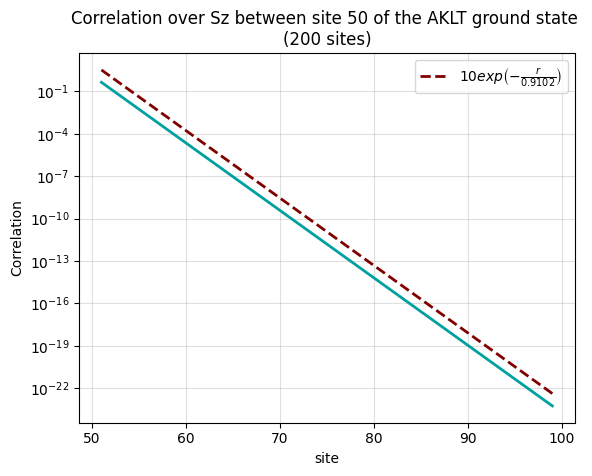

In [186]:
def exp_decay(r, A, xi):
    return A * np.exp(-r / (xi))

exp = 1/np.log(3)
a = 10

reach = 50
start = 50

correlations =psi_dmrg.correlation_function('Sz', 'Sz', sites1=[start], sites2=np.arange(start,start+reach))
correlations = np.abs(correlations.flatten())[1:]

sites_r = np.arange(len(correlations)) + start + 1


plt.plot(sites_r, correlations, lw = 2, color = '#00A0A0')
plt.plot(sites_r, exp_decay(sites_r-start, a, exp), lw = 2, alpha = 1, color = '#800000', ls = "--", label = rf'${a} exp\left(-\frac{{r}}{{{exp :.4f}}}\right)$')
plt.title(f'Correlation over Sz between site {start} of the AKLT ground state \n({L} sites)')
plt.yscale('log')
plt.xlabel('site')
plt.ylabel('Correlation')
plt.grid(alpha=0.4)
plt.legend()
plt.show()

slope:  -0.9102383449516438


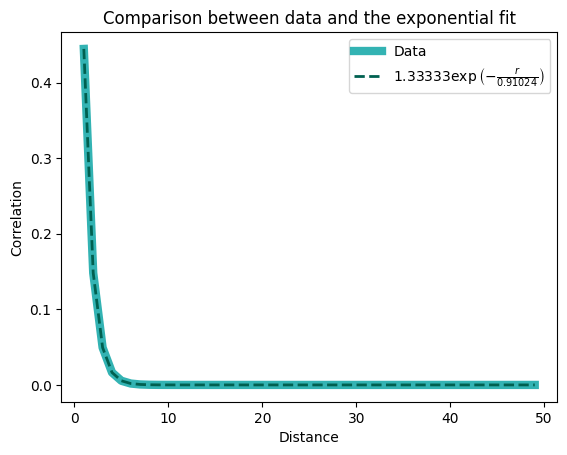

In [188]:
rs = sites_r - start
slope, intercept, r_value, p_value, std_err = stats.linregress(rs, np.log(correlations))
print("slope: ", 1/slope)


popt, _ = curve_fit(exp_decay, rs, correlations)
A_fit, xi_fit = popt
plt.plot(rs, correlations, lw = 6, alpha = .8, color = '#00A0A0', label = 'Data')
plt.plot(rs, exp_decay(rs, A_fit, xi_fit), label = rf"${A_fit :1g}\exp\left(-\frac{{r}}{{{xi_fit :.5g}}}\right)$" , lw = 2, alpha = 1., color = '#006050', ls = "--")
plt.xlabel('Distance')
plt.ylabel('Correlation')
plt.title('Comparison between data and the exponential fit')
plt.legend()
plt.show()

In [38]:
bond_energies_initial = model.bond_energies(psi_rand)
print("Bond energies of the random MPS:", bond_energies_initial)
print('bond dimensions:\n', psi_rand.chi, '\n')


bond_energies_final = model.bond_energies(psi_dmrg)
print("\nBond energies of the final MPS:", bond_energies_final)
print('bond dimensions:\n', psi_dmrg.chi)


Bond energies of the random MPS: [0.32224638 0.25444159 0.25260641 0.43971149 0.42665855 0.31941445
 0.37286476 0.39183944 0.30354103 0.27803491 0.30867238 0.34850059
 0.32873342 0.31700468 0.34242789 0.31884886 0.29726279 0.3858278
 0.38395668 0.34111958 0.34616997 0.37672129 0.32861234 0.51751466
 0.46195223 0.32095162 0.3536261  0.33477781 0.37985752 0.46737963
 0.34151024 0.48675917 0.39779049 0.4157519  0.40168295 0.38086764
 0.50862306 0.56995795 0.41410538 0.44810534 0.37049242 0.41055228
 0.51971393 0.65562018 0.40165239 0.42790295 0.27805059 0.36290841
 0.25283123]
bond dimensions:
 [3, 9, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 9, 3] 


Bond energies of the final MPS: [-0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0

In [25]:
dmrg_ground_states = []
first_excited_states = []
first_excited_energies = []
niter = 1


for biased_state in biased_states * niter:
    psi_init = generate_random_mps(model, psi0=biased_state, chi_max=chi_max, N_steps=5)
    orthogonal_states = []

    while True:
        eng = dmrg.TwoSiteDMRGEngine(psi_init, model, dmrg_params, orthogonal_to = orthogonal_states)
        E, psi_out = eng.run()
        if np.isclose(E, -(L-1)*2/3, atol=1e-5, rtol=1e-4):
            orthogonal_states.append(psi_out.copy())
            print('Found ground state with energy:', E)
        else:
            first_excited_states.append(psi_out.copy())
            first_excited_energies.append(E)
            dmrg_ground_states += orthogonal_states
            break



final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=2.15e-05


Found ground state with energy: -12.666666666666663
Found ground state with energy: -12.66666666666668


final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.74e-04


Found ground state with energy: -12.666666666666693


final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=2.87e-02


Found ground state with energy: -12.666666666666673
Found ground state with energy: -12.666666666666686


final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.92e-04


Found ground state with energy: -12.666666666666671


final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=2.89e-02


Found ground state with energy: -12.666666666666675


final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=4.93e-02


Found ground state with energy: -12.666666666666668


final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=2.86e-02


Found ground state with energy: -12.66666666666668
Found ground state with energy: -12.666666666666666


final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=7.21e-04


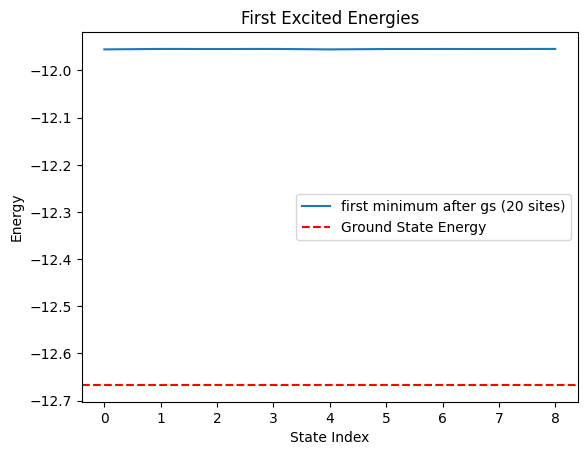

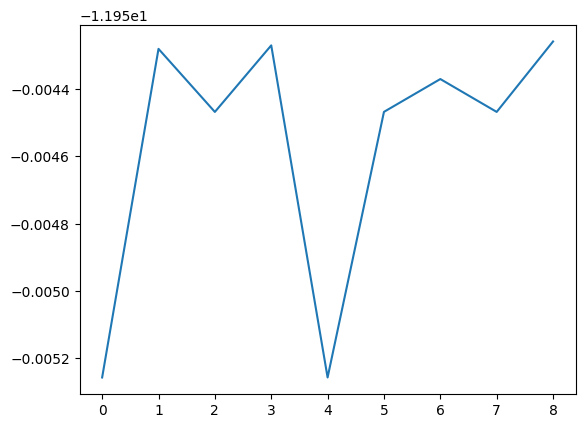

In [28]:
plt.plot(first_excited_energies, label=f'first minimum after gs ({L} sites)')
plt.axhline(y=-(L-1)*2/3, color='r', linestyle='--', label='Ground State Energy')
plt.xlabel('State Index')
plt.ylabel('Energy')
plt.title('First Excited Energies')
plt.legend()
plt.show()
plt.plot(first_excited_energies, label='first minimum after gs')
plt.show()

In [29]:
energy_gap = np.min(first_excited_energies)+(L-1)*2/3

print("Energy gap:", energy_gap)

Energy gap: 0.711408398376232


In [30]:
N = len(dmrg_ground_states)
overlap_matrix = np.zeros((N, N), dtype=np.complex128)

for i in range(N):
    for j in range(N):
        overlap_matrix[i, j] = dmrg_ground_states[i].overlap(dmrg_ground_states[j])

OL_mat = np.round(np.abs(overlap_matrix), 3)

In [31]:
# we eliminate the states that overlap with the selected state and iterate until no states are left
selected_indices = []
remaining = set(range(len(OL_mat)))

while remaining:
    i = min(remaining)
    selected_indices.append(i)
    
    overlapping = set(np.where(OL_mat[i] > 0)[0])
    
    remaining -= overlapping

print(f"Estimated degeneracy: {len(selected_indices)}")
print("Selected orthogonal state indices:", selected_indices)


Estimated degeneracy: 4
Selected orthogonal state indices: [0, 1, 2, 5]


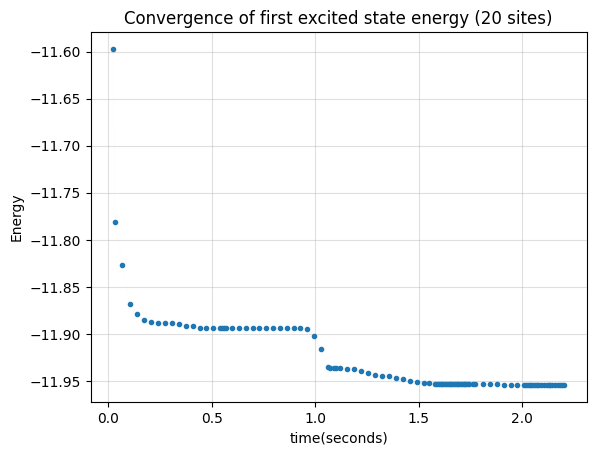

In [37]:
energies = eng.update_stats.get('E_total').copy()[:100]
times = eng.update_stats.get('time').copy()[:100]
plt.plot(times, energies, marker = '.', lw = .01)
plt.xlabel("time(seconds)")
plt.ylabel("Energy")
plt.title(f"Convergence of first excited state energy ({L} sites)")
plt.grid(alpha=0.4)
plt.show()


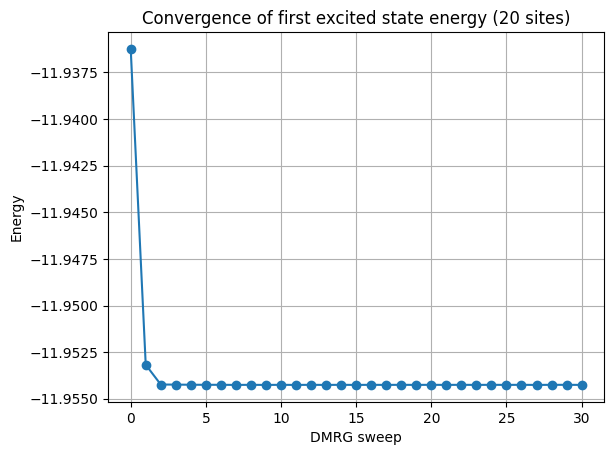

In [36]:
energies = eng.sweep_stats.get('E').copy()
plt.plot(energies, marker = 'o')
plt.xlabel("DMRG sweep")
plt.ylabel("Energy")
plt.title(f"Convergence of first excited state energy ({L} sites)")
plt.grid(True)
plt.show()


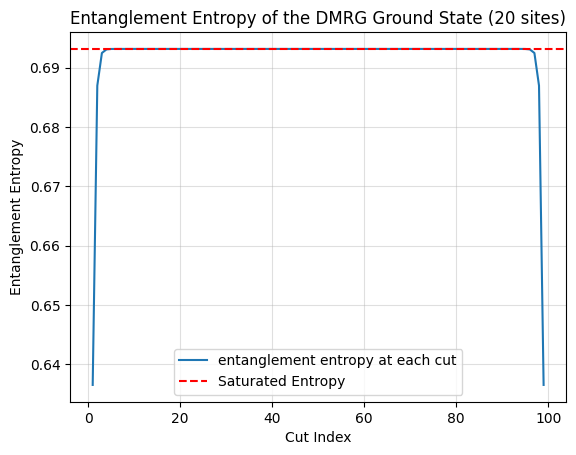

In [39]:
ee = psi_dmrg.entanglement_entropy()
plt.plot(np.arange(1,psi_dmrg.L), ee[:], label='entanglement entropy at each cut')
plt.title(f'Entanglement Entropy of the DMRG Ground State ({L} sites)')
plt.grid(alpha=0.4)
plt.xlabel('Cut Index')
plt.ylabel('Entanglement Entropy')
plt.axhline(y=np.log(2), color='r', linestyle='--', label='Saturated Entropy')
plt.legend()
plt.show()

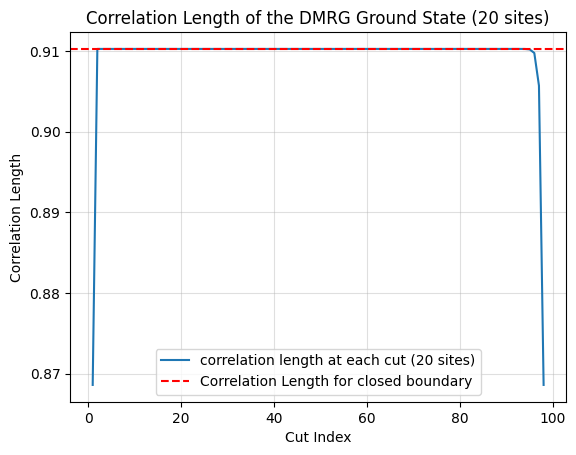

In [41]:
corr_lengths = []
for i in np.arange(1,psi_dmrg.L-1):

    A = psi_dmrg._B[i].to_ndarray().copy()

    E = np.tensordot(A, np.conj(A), axes=(1, 1)) # the transfer matrix
    E = np.transpose(E, (0, 2, 1, 3))
    sh = A.shape[0]* A.shape[2]
    E = E.reshape(sh, sh)

    vals, vecs = eigs(E, k=2, which='LM')


    vals
    vals = np.sort(np.abs(vals))[::-1]

    if vals[1] > 0:
        xi = -1 / np.log(vals[1])
    else:
        xi = np.inf

    corr_lengths.append(xi)


plt.plot(np.arange(1,psi_dmrg.L-1), corr_lengths, label=f'correlation length at each cut ({L} sites)')
plt.xlabel('Cut Index')
plt.ylabel('Correlation Length')
plt.title(f'Correlation Length of the DMRG Ground State ({L} sites)')
plt.grid(alpha=0.4)
plt.axhline(y=0.9102392289240578, color='r', linestyle='--', label='Correlation Length for closed boundary')
plt.legend()
plt.show()

In [ ]:
psi_dmrg.correlation_length()
# closed boundary conditions only

np.float64(0.9102392289240578)

Finished DMRG for L=4, chi_max=4 in 0.08 seconds
Finished DMRG for L=4, chi_max=9 in 0.08 seconds
Finished DMRG for L=4, chi_max=24 in 0.08 seconds
Finished DMRG for L=4, chi_max=60 in 0.08 seconds
Finished DMRG for L=4, chi_max=150 in 0.08 seconds
Finished DMRG for L=9, chi_max=4 in 0.25 seconds
Finished DMRG for L=9, chi_max=9 in 0.43 seconds
Finished DMRG for L=9, chi_max=24 in 0.53 seconds
Finished DMRG for L=9, chi_max=60 in 0.80 seconds
Finished DMRG for L=9, chi_max=150 in 3.86 seconds
Finished DMRG for L=24, chi_max=4 in 0.83 seconds
Finished DMRG for L=24, chi_max=9 in 1.58 seconds
Finished DMRG for L=24, chi_max=24 in 2.26 seconds
Finished DMRG for L=24, chi_max=60 in 3.99 seconds
Finished DMRG for L=24, chi_max=150 in 44.52 seconds
Finished DMRG for L=60, chi_max=4 in 2.22 seconds
Finished DMRG for L=60, chi_max=9 in 4.33 seconds
Finished DMRG for L=60, chi_max=24 in 5.98 seconds
Finished DMRG for L=60, chi_max=60 in 10.08 seconds
Finished DMRG for L=60, chi_max=150 in 131.7

/home/kia/Desktop/PoD/myenv/lib/python3.12/site-packages/tenpy/tools/params.py:232: UserWarning: unused option ['max_E_err'] for config TwoSiteDMRGEngine
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Finished DMRG for L=150, chi_max=24 in 17.78 seconds
Finished DMRG for L=150, chi_max=60 in 27.88 seconds
Finished DMRG for L=150, chi_max=150 in 278.23 seconds


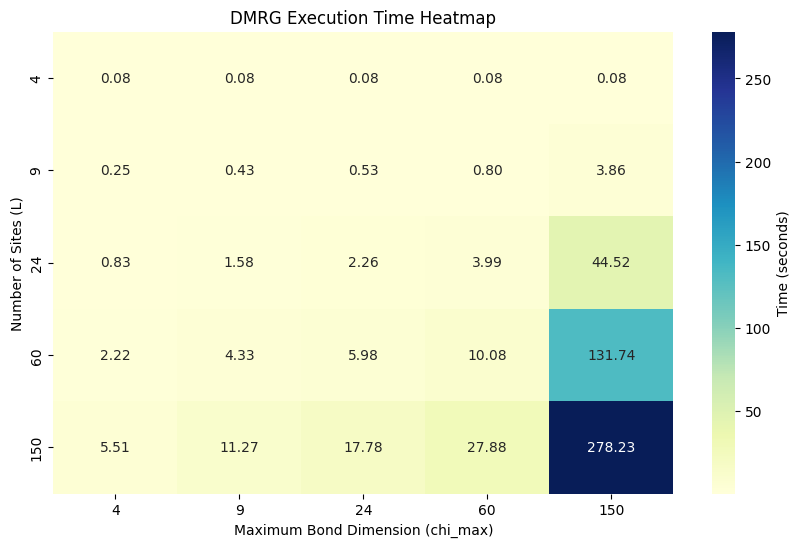

2.098321516541546e-14 is the higest error for the ground state energy. seems to be nothing more than a rounding error.


In [ ]:
Llist = np.logspace(np.log10(4), np.log10(150), 5, dtype=int)
CHIlist = np.logspace(np.log10(4), np.log10(150), 5, dtype=int)
Times = np.zeros((len(Llist), len(CHIlist)))
Energies = np.zeros((len(Llist), len(CHIlist)))


for i in range(len(Llist)):
    for j in range(len(CHIlist)):
        chi_max = int(CHIlist[j])
        L = int(Llist[i])
        model = AKLTChain({'L': L, 'bc_MPS': 'finite'})
        psi_gs = model.psi_AKLT()
        dmrg_params = {
            'mixer': True,
            'max_E_err': 1e-4,
            'max_sweeps': 2,
            'min_sweeps': 2,
            'trunc_params': {'chi_max': chi_max},
        }
        psi_init = generate_random_mps(model, chi_max=chi_max, N_steps=1)
        dmrg_engine = dmrg.TwoSiteDMRGEngine(psi_init, model, dmrg_params)

        try:
            start = time.time()
            E0, psi_dmrg = dmrg_engine.run()
            end = time.time()
            E0 /= (L-1)
            E0 += 2/3
        except Exception as e:
            print(f"Error for L={L}, chi_max={chi_max}: {e}")
            E0 = np.nan
            start = 0.
            end = 0.

        print(f"Finished DMRG for L={L}, chi_max={chi_max} in {end - start:.2f} seconds")


        Times[i, j] = end - start
        Energies[i, j] = E0


plt.figure(figsize=(10, 6))
sns.heatmap(Times, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=CHIlist, yticklabels=Llist,
            cbar_kws={'label': 'Time (seconds)'})
plt.title('DMRG Execution Time Heatmap')
plt.xlabel('Maximum Bond Dimension (chi_max)')
plt.ylabel('Number of Sites (L)')
plt.show()

print(f"{np.max(Energies)} is the higest error for the ground state energy. seems to be nothing more than a rounding error.")
# plt.figure(figsize=(10, 6))
# sns.heatmap(Energies, annot=True, fmt=".2f", cmap="YlGnBu",
#             xticklabels=CHIlist, yticklabels=Llist,
#             cbar_kws={'label': 'Energy'})
# plt.title('DMRG Ground State Energy error Heatmap')
# plt.xlabel('Maximum Bond Dimension (chi_max)')
# plt.ylabel('Number of Sites (L)')
# plt.show()

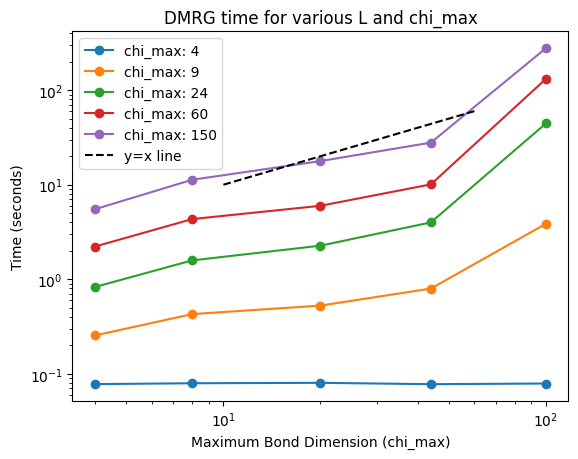

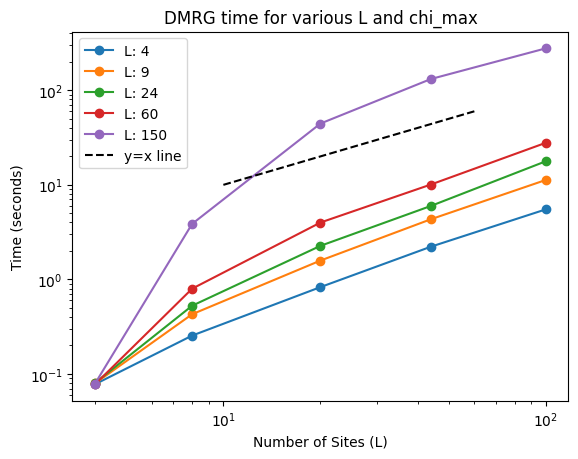

In [224]:
for i in range(len(Times)):
    row = Times[i]
    row[row == 0] = np.nan

    plt.loglog(np.logspace(np.log10(4), np.log10(100), 5, dtype=int), row, label=f"chi_max: {CHIlist[i]}", marker = "o")

plt.ylabel("Time (seconds)")
plt.xlabel("Maximum Bond Dimension (chi_max)")
plt.plot(np.arange(10,100,50), np.arange(10,100,50), ls = "--", color = "black", label = "y=x line")
plt.title("DMRG time for various L and chi_max")
plt.legend()
plt.show()


for i in range(len(Times)):
    col = Times[:,i]
    col[col == 0] = np.nan

    plt.loglog(np.logspace(np.log10(4), np.log10(100), 5, dtype=int), col, label=f"L: {Llist[i]}", marker = "o")

plt.ylabel("Time (seconds)")
plt.xlabel("Number of Sites (L)")
plt.plot(np.arange(10,100,50), np.arange(10,100,50), ls = "--", color = "black", label = "y=x line")
plt.title("DMRG time for various L and chi_max")
plt.legend()
plt.show()

In [ ]:
# # to inspect the 2 site local Hamiltonian:
# H_local = model.H_bond[1].to_ndarray()

# # to inspect the MPO at some site:
# H_MPO_example = np.round(model.H_MPO._W[0].to_ndarray(), 3)

# # to inspect the MPS at some site:
# psi_example = np.round(psi_gs._B[1].to_ndarray(), 3)

In [222]:
print("first site       last site", '\n\n')
for i, index in enumerate(selected_indices):
    
    gs = dmrg_ground_states[index]
    gsh = gs._B[0].to_ndarray()
    gst = gs._B[-1].to_ndarray().T

    if np.max(np.imag(gsh)) < 1e-6:
        gsh = np.real(gsh)

    if np.max(np.imag(gst)) < 1e-6:
        gst = np.real(gst)

    print(f'ground state {i+1}: \n')
    print(gsh[:,0,:], '    ', gst[:,0,:], '\n\n', gsh[:,1,:], '    ', gst[:,1,:], '\n\n', gsh[:,2,:], '    ', gst[:,2,:], '\n\n\n\n')

first site       last site 


ground state 1: 

[[-1.  0.]]      [[0. 0.]] 

 [[0. 1.]]      [[0. 1.]] 

 [[0. 0.]]      [[1. 0.]] 




ground state 2: 

[[-1.  0.]]      [[0. 1.]] 

 [[ 0. -1.]]      [[1. 0.]] 

 [[0. 0.]]      [[0. 0.]] 




ground state 3: 

[[0. 0.]]      [[0. 1.]] 

 [[-1.  0.]]      [[1. 0.]] 

 [[ 0. -1.]]      [[0. 0.]] 




ground state 4: 

[[0. 0.]]      [[0. 0.]] 

 [[1. 0.]]      [[0. 1.]] 

 [[ 0. -1.]]      [[1. 0.]] 






In [210]:
gs = psi_dmrg
r = np.random.randint(0, gs.L-1)
gsarr = gs._B[r].to_ndarray()
gsarr = np.real(gsarr)
print('looking at a random site of the converged state:\n\n')

print('shape:', gsarr.shape, '\n\n')
print(gsarr[:,0,:], '\n\n')
print(gsarr[:,1,:], '\n\n')
print(gsarr[:,2])


looking at a random site of the converged state:


shape: (2, 3, 2) 


[[ 0.          0.        ]
 [-0.81649658  0.        ]] 


[[-0.57735027  0.        ]
 [ 0.          0.57735027]] 


[[0.         0.81649658]
 [0.         0.        ]]
